## Importation des données

In [22]:
import pandas as pd
import numpy as np


In [53]:
import json
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [16, 6] # default = [6.0, 4.0]
plt.rcParams['figure.dpi']     = 200     # default = 72.0
plt.rcParams['font.size']      = 7.5     # default = 10.0

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, ShuffleSplit

from sklearn.utils import all_estimators
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import ARDRegression
from sklearn.linear_model import SGDRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings("ignore")

In [3]:
data = pd.read_csv('SeoulBikeData.csv', sep=',')

In [4]:
data.head()

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


## Transformation des mots en chiffre

In [83]:
data['Holiday (int)'] = data['Holiday'].apply(lambda x: 0 if x == 'No Holiday' else 1)

data.loc[data['Seasons'] == 'Winter', 'Seasons (int)'] = 1
data.loc[data['Seasons'] == 'Spring', 'Seasons (int)'] = 2
data.loc[data['Seasons'] == 'Summer', 'Seasons (int)'] = 3
data.loc[data['Seasons'] == 'Autumn', 'Seasons (int)'] = 4

data['Functioning Day (int)'] = data['Functioning Day'].apply(lambda x: 1 if x == 'Yes' else 0)



data['Date'] = pd.to_datetime(data['Date'], format="%d/%m/%Y")
data.head()

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day,Holiday (int),Seasons (int),Functioning Day (int)
0,2017-12-01,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,0,1.0,1
1,2017-12-01,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,0,1.0,1
2,2017-12-01,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes,0,1.0,1
3,2017-12-01,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,0,1.0,1
4,2017-12-01,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes,0,1.0,1


In [6]:
df = data.drop(['Holiday', 'Date', 'Seasons', 'Functioning Day'], axis=1)

# Valeurs nulles

In [31]:
data.isnull().sum()

Date                         0
Rented Bike Count            0
Hour                         0
Temperature(°C)              0
Humidity(%)                  0
Wind speed (m/s)             0
Visibility (10m)             0
Dew point temperature(°C)    0
Solar Radiation (MJ/m2)      0
Rainfall(mm)                 0
Snowfall (cm)                0
Seasons                      0
Holiday                      0
Functioning Day              0
Holiday (int)                0
Seasons (int)                0
Functioning Day (int)        0
dtype: int64

Il n'y a pas de valeur nulle. Cela facilite le traitement des données.

In [7]:
import matplotlib.pyplot as plt
import seaborn as sn

## Visualisation de la matrice de corrélation

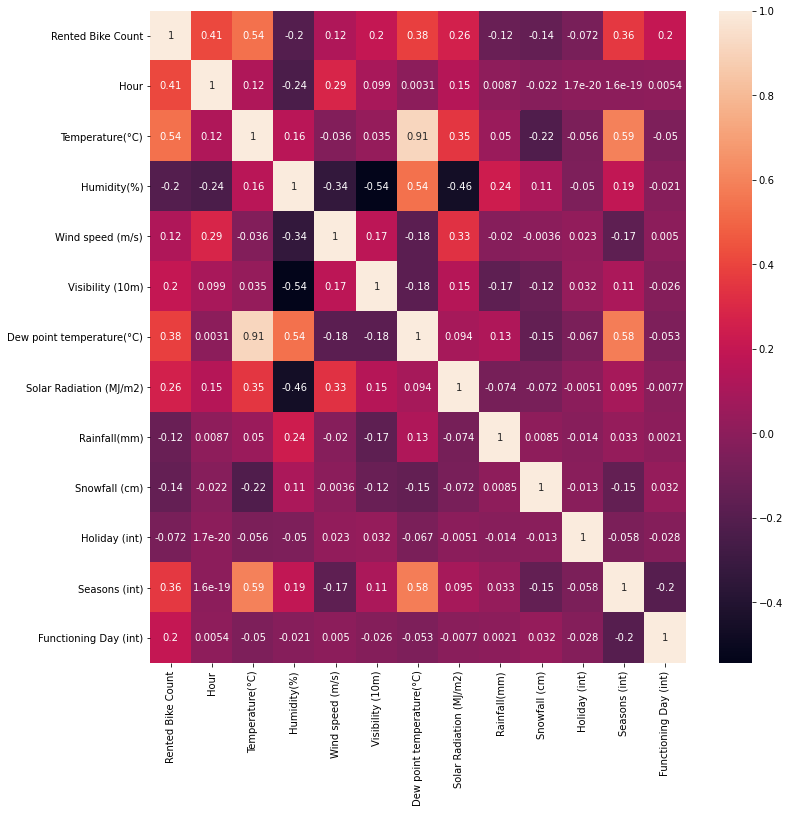

In [8]:
plt.figure(figsize = (12,12))
sn.heatmap(df.corr(), annot=True)
plt.show()

In [9]:
# importante correlation avec la température, moyenne avec l'heure
#, le point de rosée (Dew point), l'intensité du soleil et la saison
# 
#
#

Il n'y a que une faible correlation avec Holiday. On va par la suite ne pas prendre en compte cette variable.

# Functioning day (int)

In [39]:
data.groupby(['Functioning Day (int)']).agg({'Rented Bike Count': ['sum']}).reset_index()

,Functioning Day (int),Rented Bike Count
,,sum
0,0,0
1,1,6172314


Il n'y a pas de vélo emprunté lorsque nous ne sommes pas en jour de fonctionnement. Nous ne prendrons donc pas en compte cette variable par la suite.

creation d'un 2eme tableau data_no_functioning_day

In [85]:
data_no_functioning_day = data[data['Functioning Day (int)'] == 1].drop('Functioning Day (int)', axis=1)
print(f'before: {len(data)}')
print(f'after: {len(data_no_functioning_day)}')

before: 8760
after: 8465


# Rented Bike Count

Le but du dataset est visiblement de prévoir, à l'aide des données météologiques et horaires, le nombre de vélo à prévoir par heure. Nous allons donc le visualiser.

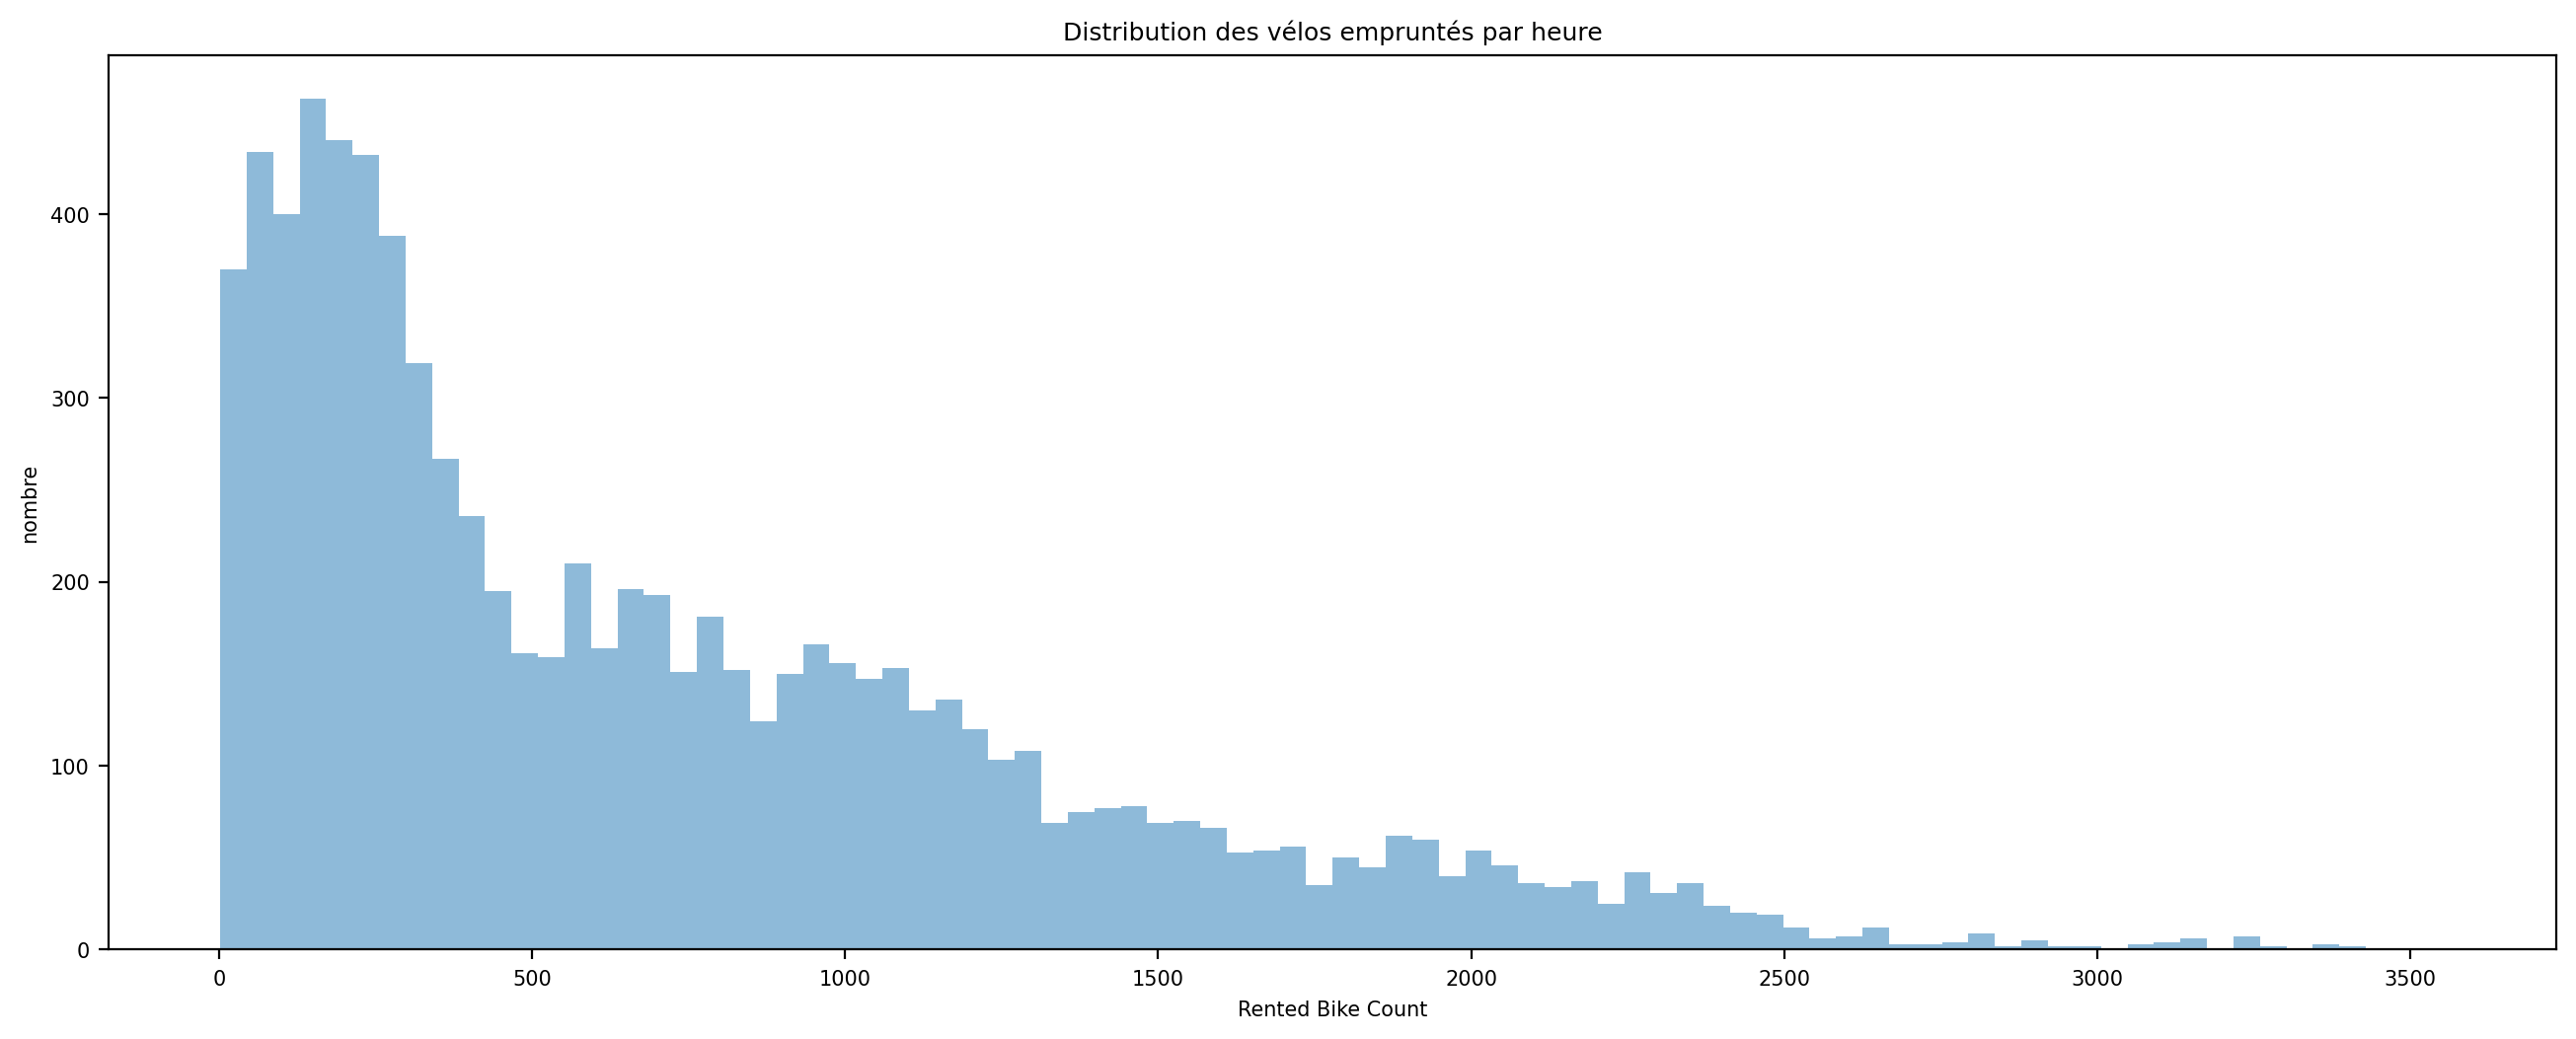

In [86]:
N = len(data_no_functioning_day) // 100

plt.hist(x=data_no_functioning_day['Rented Bike Count'], bins=N, alpha=0.5)
plt.title('Distribution des vélos empruntés par heure')
plt.xlabel('Rented Bike Count')
plt.ylabel('nombre')
pass

Notre histogramme est applatie sur la gauche, nous allons donc utiliser une transformation racine (sqrt) pour obtenir une gaussienne.

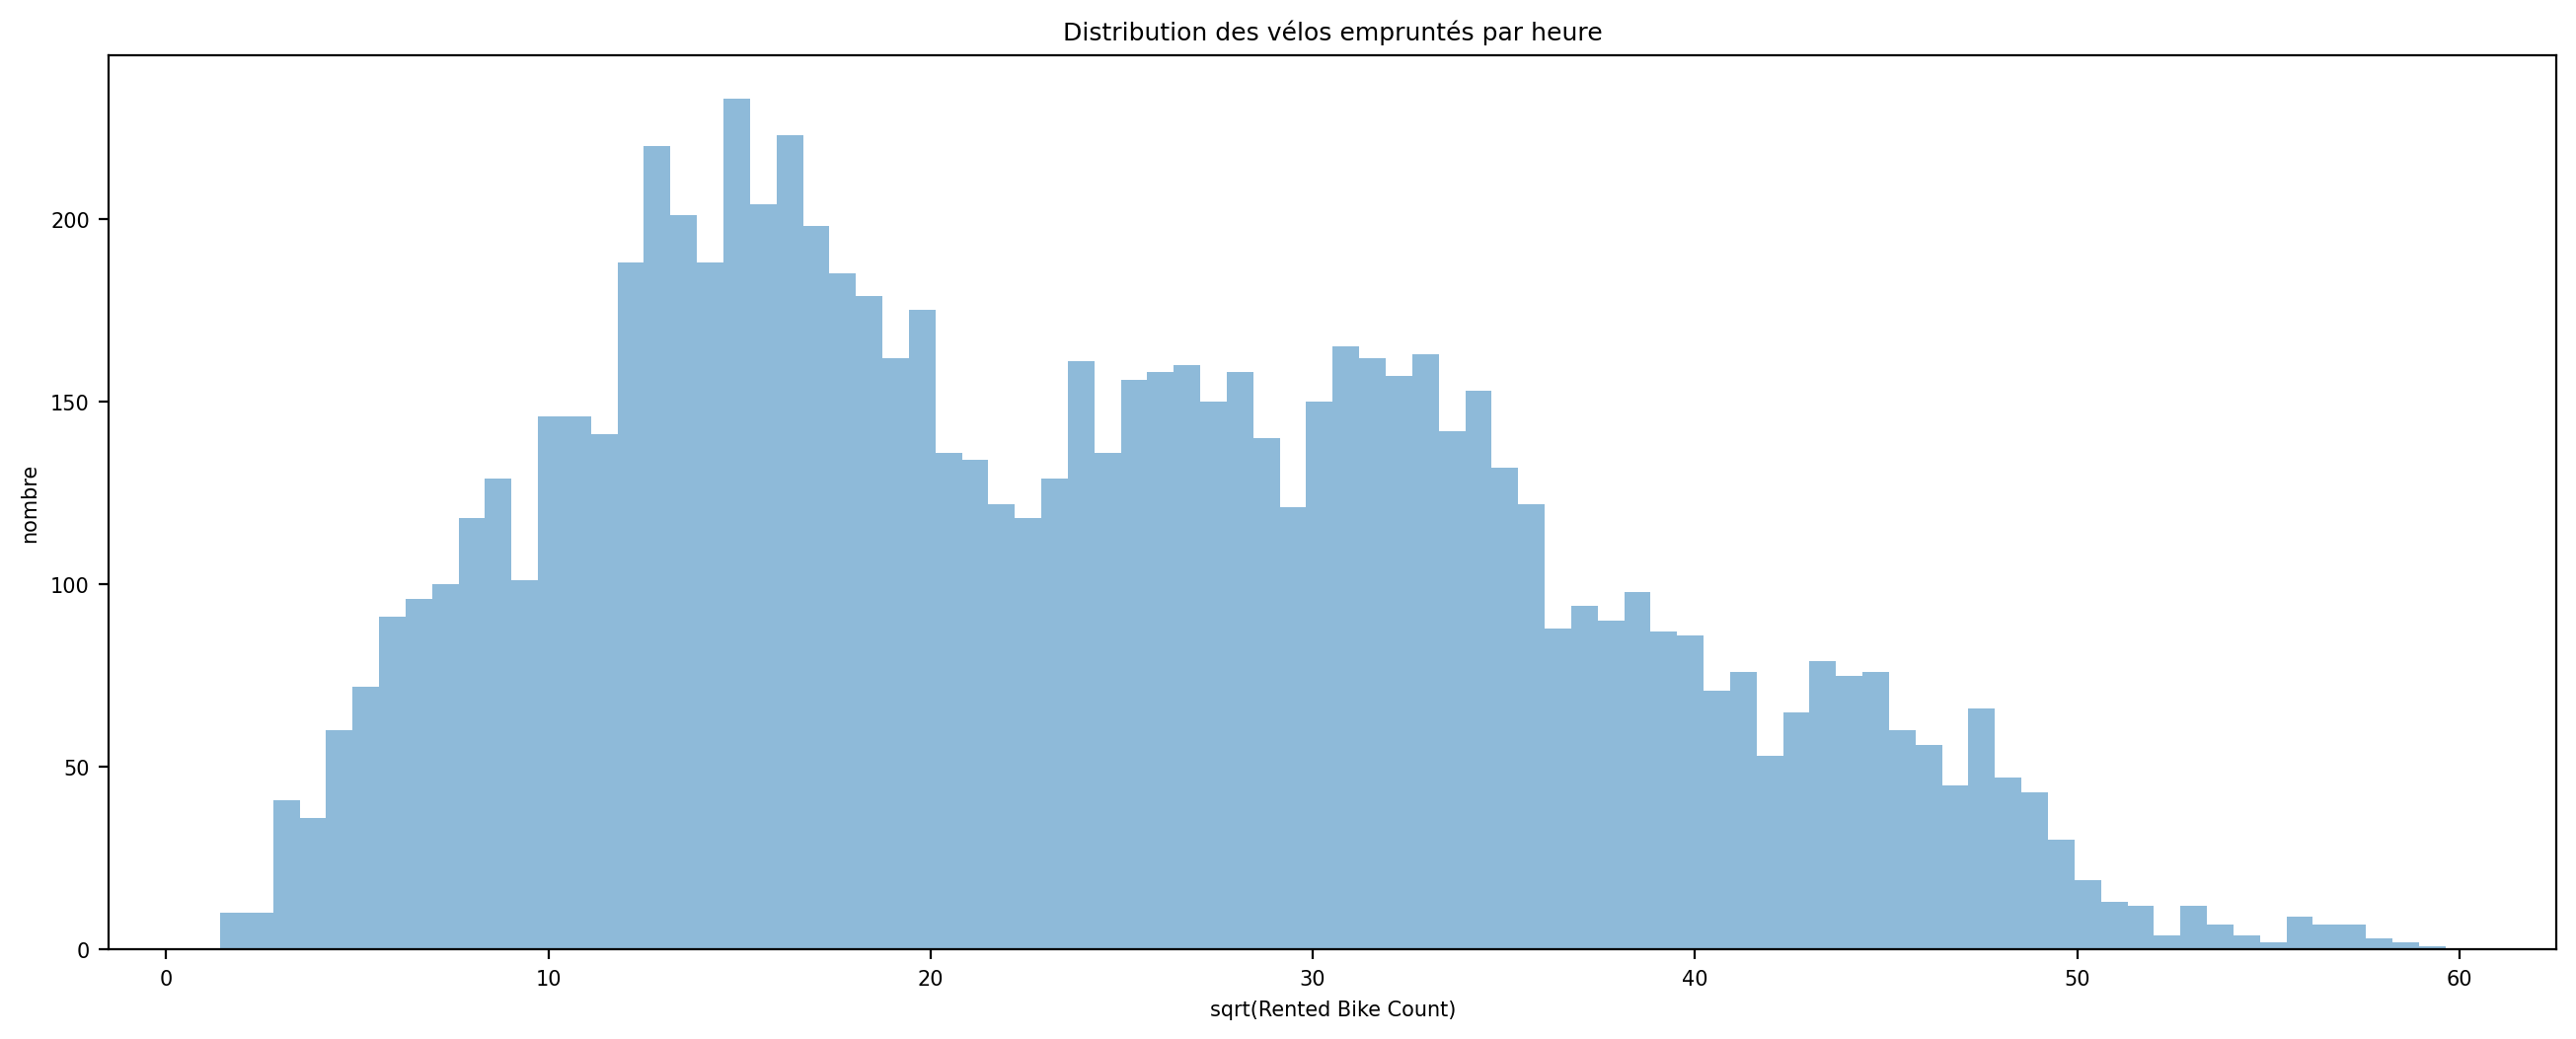

In [87]:
plt.hist(x=np.sqrt(data_no_functioning_day['Rented Bike Count']), bins=N, alpha=0.5)
plt.title('Distribution des vélos empruntés par heure')
plt.xlabel('sqrt(Rented Bike Count)')
plt.ylabel('nombre')
pass

Maintenant, visualisons le nombre de vélo emprunté en fontion de l'heure et la date

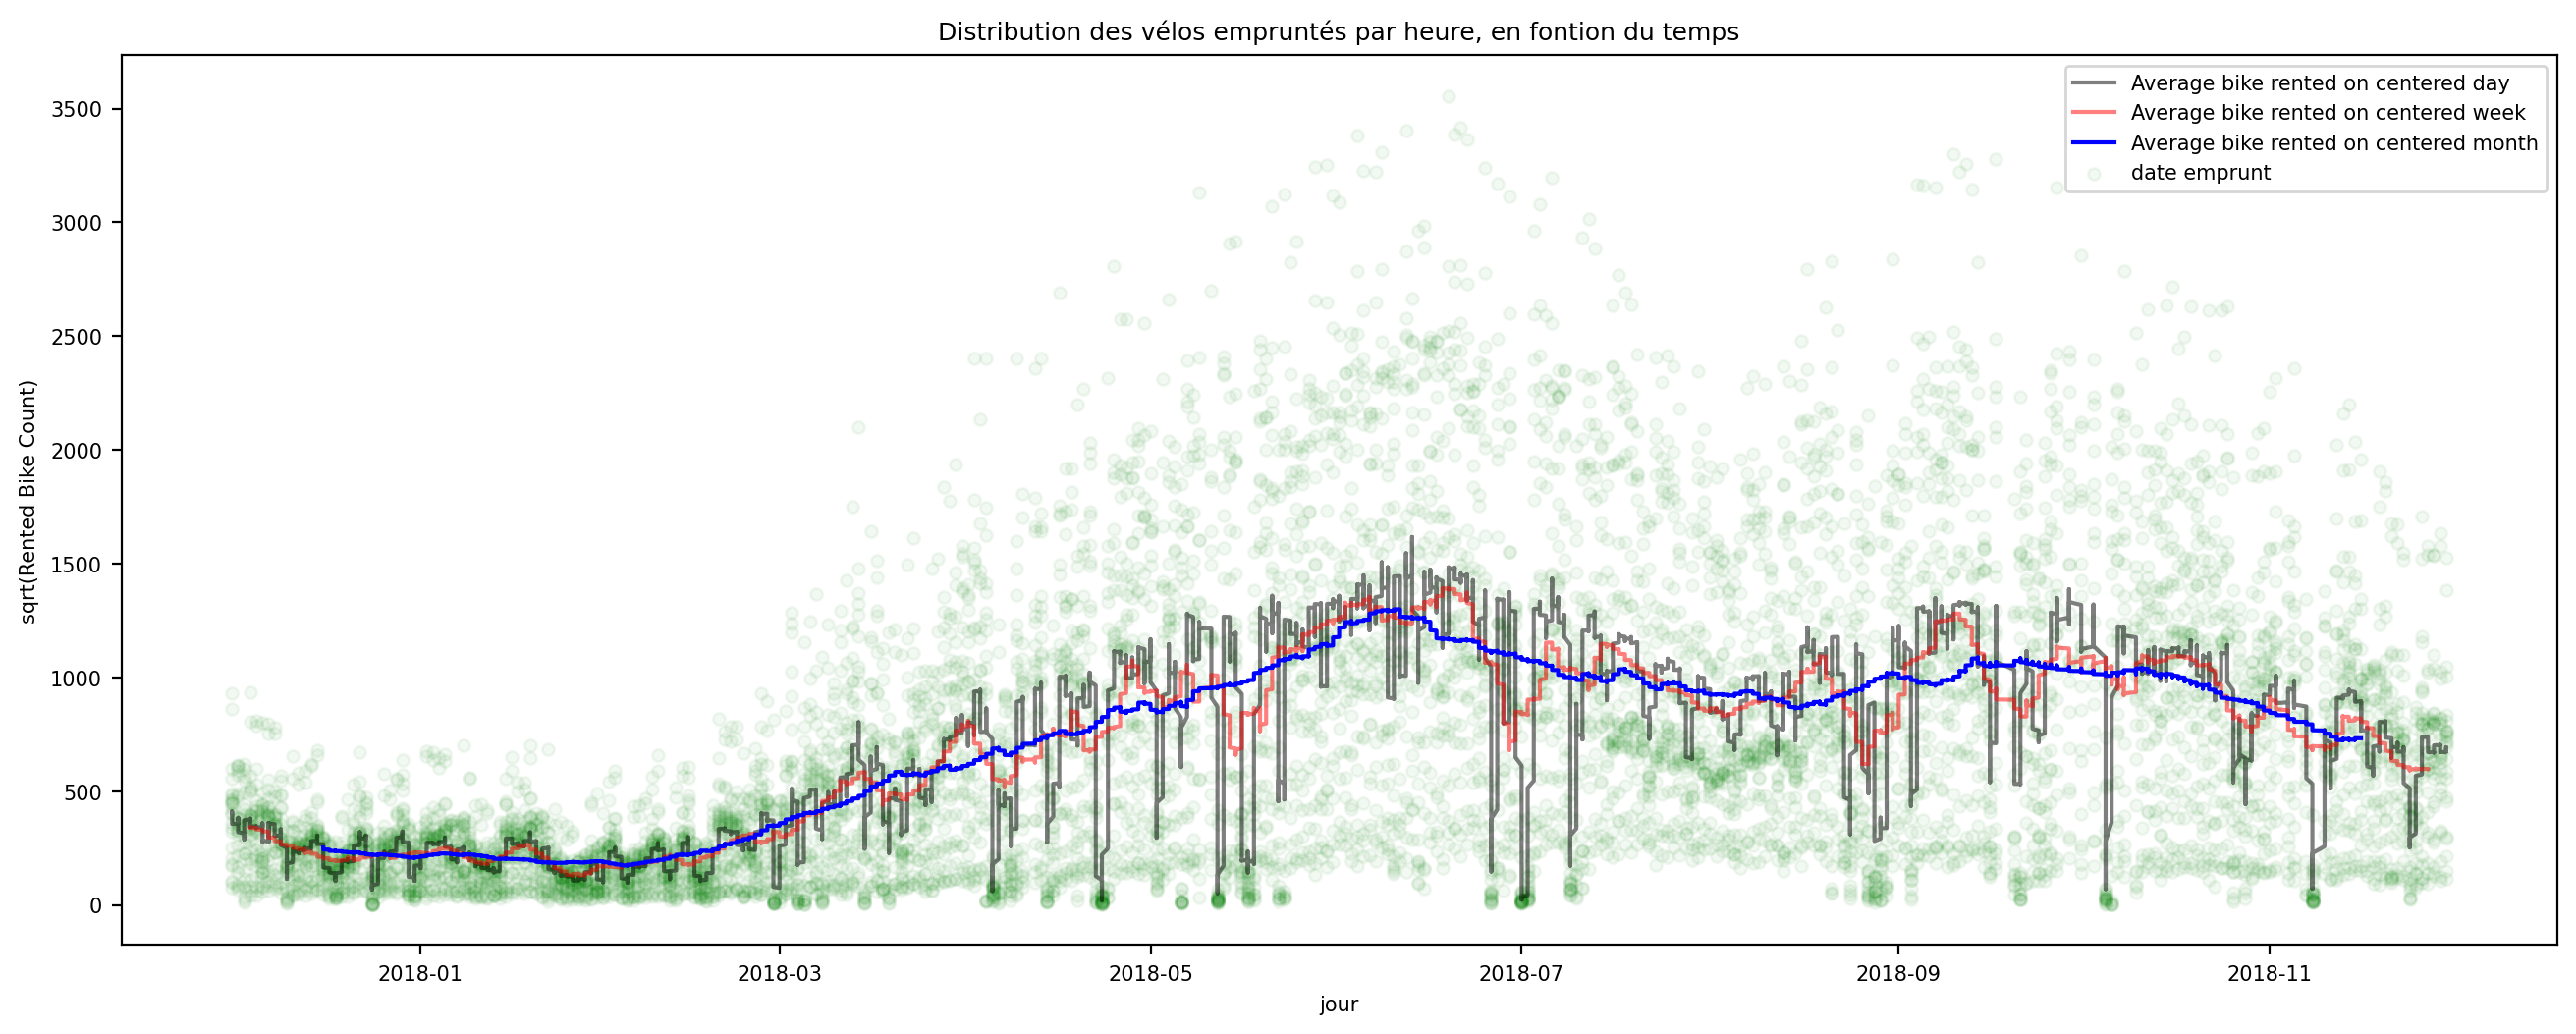

In [103]:
data_no_functioning_day.plot(x='Date', y='Rented Bike Count', alpha=0.05, kind='scatter', color='green', label='date emprunt')

plt.plot(data_no_functioning_day['Date'], data_no_functioning_day['Rented Bike Count'].rolling(1*24, center=True).mean(), color='black', alpha=0.5, label='Average bike rented on centered day') 
plt.plot(data_no_functioning_day['Date'], data_no_functioning_day['Rented Bike Count'].rolling(7*24, center=True).mean(), color='red', alpha=0.5, label='Average bike rented on centered week') 
plt.plot(data_no_functioning_day['Date'], data_no_functioning_day['Rented Bike Count'].rolling(30*24, center=True).mean(), color='blue', label='Average bike rented on centered month') 
plt.legend()
plt.title('Distribution des vélos empruntés par heure, en fontion du temps')
plt.xlabel('jour')
plt.ylabel('sqrt(Rented Bike Count)')
pass

Nous pouvons voir que le nombre d'emprunt varie significativement en fonction mois de l'année.
Il y a des différences en fonction des semaines et des jours, mais cela n'est pas suffisament régulier pour les deux afin de pouvoir en dire quelque chose pour le moment.

# Différence week-end et jour de la semaine

In [110]:
#plot we et jour de semaine

# Météo

## Température

## Humidité

## Vitesse du vent

## Visibilité

## Point de Rosé

## Quantité de soleil

## Quantité de Pluie

## Neige

## Saison

In [ ]:
import scipy.stats as stats

In [ ]:
stats.probplot(df['Rented Bike Count'], plot=plt)

## Machine learning

### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
X = df.iloc[:, 1:13]
# X = df.iloc[:, [1,2,6,7,11]]
y = df.iloc[:, 0]
X = X.values
y = y.values

In [ ]:
n_train = int(len(y)*0.75)
trainX , testX = X[:n_train , :] ,X[ n_train:, :]
trainy , testy = y[:n_train ], y[ n_train:]

In [ ]:
clf = LogisticRegression(random_state=0).fit(trainX, trainy)

In [ ]:
clf.score(testX, testy)

### SVM

In [11]:
from sklearn import svm
from sklearn import grid_search

ImportError: cannot import name 'grid_search' from 'sklearn' (D:\programmes\anaconda3\lib\site-packages\sklearn\__init__.py)

In [ ]:
# clfsvm = svm.SVC(kernel='linear', C=100).fit(trainX, trainy)
# clfsvm.score(testX, testy)

In [ ]:
parameters = {  'C'       : [190, 200, 250, 260]   ,
                'kernel'  : ['rbf'],
                'gamma'   : [ 0.03],
                  "epsilon" : [1.5, 2, 2.5],
                 "degree" : [1,2]}
grid = grid_search.GridSearchCV(svm.SVR(), parameters, n_jobs=-1)
grid.fit(trainX, trainy)
print grid.best_score_, grid.best_estimator_